# Experiment 05a

Run different models on ctec dataset itself without jigsaw dataset. 

Given that ctec dataset is imbalanced and has overwhelmingly more positive examples, we upsample negative examples. 

<ul>
    <li>Tokenizer: BERT</li>
    <li>Training set: 10800 ctec positive + 1350 ctec negative (8:1 ratio) </li>
    <li>Validation set: 1200 ctec positive + 150 ctec negative (8:1 ratio) </li>
    <li>Test set: 9600 ctec positive + 401 ctec negative</li>
    <li>Upsampling technique: <span style="color:red"><b>naive duplication</b></span></li>
    <li>Models: Logistic Regression, Multilayer Perceptron, BERT</li>
</ul>

## Part 1: Preparation

### Load data

In [1]:
# 0 --> testing mode 
# 1 --> development mode 
toy_mode = 0
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from math import inf

# Define constants 
MAX_LEN = 300    # Max text length for encoding purpose 
BATCH_SIZE = 16
PRETRAINED_BERT_NAME = 'bert-base-uncased'
SESS_PWD = './xprmt_05a/'

# Enable GPU if possible 
device = torch.device(
    'cuda:0' if torch.cuda.is_available() else 'cpu'
)
print(f'device = {device}')

device = cuda:0


In [2]:
# Load ctec dataset 
ctec_df = pd.read_csv('ctec_training_data_preproc.csv')

ctec_neg = ctec_df[ctec_df['label'] == 0]
ctec_pos = ctec_df[ctec_df['label'] == 1]

print(f'ctec # negative examples = {ctec_neg.shape[0]}')
print(f'ctec # positive examples = {ctec_pos.shape[0]}')

ctec # negative examples = 1901
ctec # positive examples = 21600


### Train-val-test split

In [3]:
# Randomly sampling indices 
np.random.seed(42)

# Indices for train & validation set 
indpos_trainval = np.random.choice(range(ctec_pos.shape[0]), size = 12000, replace = False)
indneg_trainval = np.random.choice(range(ctec_neg.shape[0]), size = 1500, replace = False)

# Indices for test set 
indpos_test = np.setdiff1d(range(ctec_pos.shape[0]), indpos_trainval)
indneg_test = np.setdiff1d(range(ctec_neg.shape[0]), indneg_trainval)

# Indices for train set 
indpos_train = np.random.choice(indpos_trainval, size = 10800, replace = False)
indneg_train = np.random.choice(indneg_trainval, size = 1350, replace = False)

# Indices for cross-validation set 
indpos_val = np.setdiff1d(indpos_trainval, indpos_train)
indneg_val = np.setdiff1d(indneg_trainval, indneg_train)

ctec_train_origin = ctec_pos.iloc[indpos_train].append(
    ctec_neg.iloc[indneg_train], 
    ignore_index = True
)

ctec_val = ctec_pos.iloc[indpos_val].append(
    ctec_neg.iloc[indneg_val], 
    ignore_index = True
)

ctec_test = ctec_pos.iloc[indpos_test].append(
    ctec_neg.iloc[indneg_test], 
    ignore_index = True
)

### Upsampling

In [4]:
# Upsample training set by naively duplicating negative examples 
# pos:neg = 8:3 ratio 
ctec_train_upsamp = ctec_train_origin.append(
    ctec_neg.iloc[indneg_train], 
    ignore_index = True
).append(
    ctec_neg.iloc[indneg_train], 
    ignore_index = True
)

# Shuffle the upsampled data
ctec_train_unsamp = ctec_train_upsamp.sample(n = ctec_train_upsamp.shape[0], replace = False).reset_index(drop = True)

### Prepare input and label

`toy_mode = 1` means we are in development mode and will only load very little number of dataset, so that we can debug without wasting time wating for results. 

`toy_mode = 0` means we are in testing mode and will load all data. 

In [5]:
X_train_text = ctec_train_upsamp['comment_text']
y_train = ctec_train_upsamp['label']
X_val_text = ctec_val['comment_text']
y_val = ctec_val['label']
X_test_text = ctec_test['comment_text']
y_test = ctec_test['label']

if toy_mode: 
    X_train_text = X_train_text[:50]
    y_train = y_train[:50]
    X_val_text = X_val_text[:30]
    y_val = y_val[:30]
    X_test_text = X_test_text[:20]
    y_test = y_test[:20]

For convenience of creating PyTorch `DataSet`, we will will fit `CountVectorizer()` and `TfidfVectorizer` for later use. 

In [6]:
countVect = CountVectorizer()
countVect.fit(X_train_text)

tfidfVect = TfidfVectorizer()
tfidfVect.fit(X_train_text)

bertTokenizer = BertTokenizer.from_pretrained(PRETRAINED_BERT_NAME)

### Text encoding \& creating PyTorch `Dataset`, `DataLoader`

To utilize PyTorch and GPU computation, we create instances of `Dataset` instead of using our original dataset. 

<b>Notice. </b> Text encoding is performed inside `__getitem()__` function of `Dataset` class. 

`DataLoader` provides a way to iterate through a dataset with given batch size. 

<b style="color:red">Attention! </b> All first-initialized PyTorch tensors must be moved to GPU memory manually! Pay attention when you initialize a PyTorch tensor! 

In [7]:
class ToxicDataset(Dataset): 
    def __init__(self, texts, labels, tokenizer, max_len = MAX_LEN): 
        '''
        Instantiate ToxicDataset() class 
        @Params
        -- texts: comments texts of the dataset (input)
        -- labels: labels corresponding to the texts 
        -- tokenizer: {'bow', 'tfidf', 'bert'} the scheme of encoding texts into numerical data
        -- max_len: if we use BERT tokenizer, we represent texts with `max_len`-dim vectors
        '''
        super().__init__()
        self.texts = texts 
        self.labels = labels 
        self.tokenizer = tokenizer
        self.max_len = max_len 
        
    def __len__(self): 
        '''Return the size of dataset '''
        return len(self.texts)
    
    def __getitem__(self, idx): 
        '''This method must be overwritten by programmer '''
        
        text = str(self.texts[idx])
        # Vector embedding of text. Will be computed by tokenizer 
        input_vec = None
        # Must be PyTorch tensor 
        label = torch.tensor(
            self.labels[idx], 
            dtype = torch.long
        ).to(device)
        # Only applicable to BERT
        attention_mask = None
        
        '''
        Encode text data according to the given tokenizer
        The result of encoding must be PyTorch Tensor. 
        '''
        # BoW encoding 
        if self.tokenizer == 'bow': 
            input_vec = torch.Tensor(
                countVect.transform([text]).toarray()
            ).to(device).flatten()
            
        # TF-IDF encoding
        elif self.tokenizer == 'tfidf': 
            input_vec = torch.Tensor(
                tfidfVect.transform([text]).toarray()
            ).to(device).flatten()
            
        # BERT encoding 
        elif self.tokenizer == 'bert': 
            encoding = bertTokenizer.encode_plus(
                text, 
                add_special_tokens = True, 
                truncation = True, 
                max_length = self.max_len, 
                return_token_type_ids = False, 
                pad_to_max_length = True, 
                return_attention_mask = True, 
                return_tensors = 'pt'
            )
            
            input_vec = encoding['input_ids'].to(device).flatten()
            attention_mask = encoding['attention_mask'].to(device).flatten()
            
        return {
            'text': text, 
            'input_vec': input_vec, 
            'input_size': input_vec.shape[0], 
            'attention_mask': attention_mask, 
            'label': label
        }

In [8]:
def create_data_loader(
    texts, labels, 
    tokenizer, 
    batch_size = BATCH_SIZE, 
    max_len = MAX_LEN
): 
    '''
    Helper function for creating DataLoader.  
    @Params
    -- texts: comments texts of the dataset (input)
    -- labels: labels corresponding to the texts 
    -- tokenizer: {'bow', 'tfidf', 'bert'} the scheme of encoding texts into numerical data
    -- batch_size: (as the name suggests)
    -- max_len: if we use BERT tokenizer, we represent texts with `max_len`-dim vectors
    '''
    
    dataset = ToxicDataset(
        texts = texts, 
        labels = labels, 
        tokenizer = tokenizer, 
        max_len = max_len
    )
    
    return DataLoader(
        dataset, 
        batch_size = batch_size, 
        num_workers = 0    # We can change this value to enable multiprocessing
    )

Now we can finally instantiate `DataLoader`s for training, validation, and test set. 

(For now) we only use BERT tokenizer and leave alone BoW and TF-IDF. 

In [9]:
train_data_loader = create_data_loader(
    X_train_text, y_train, 'bert'
)

val_data_loader = create_data_loader(
    X_val_text, y_val, 'bert'
)

test_data_loader = create_data_loader(
    X_test_text, y_test, 'bert'
)


<b>A key question I have not solved</b>. Normalizing features can usually boost the performance of machine learning models. Under the current coding style where text encoding is performed inside `Dataset`, how do we write the function for normalizing features? 

Pros and cons for writing the encoding routine inside `Dataset`: 

<ul>
    <li>Pros: can specify encoding scheme by an argument, and will be convenience for grid-searching. </li>
    <li>Cons: hard to implement normalization and other possible routines. </li>
</ul>

## Part 2: Models and model-specific parameters

### Create model class

We define our models / classifiers by inherting and overwriting `nn.Module` class. 

<b>Model-specific hyperparameters</b> (<span style="color:blue;">hidden layers, drop-out rate, etc.<span/>) should be defined as attributes of each model class. 
    
<b style="color:red">Attention! </b> `__init__()` must use clases in `torch.nn` module specify inter-layer operations that (1) have parameters to train or (2) change dimensionality (e.g. linear map, convolution, dropout); on the other hand, all operations within layer without trained parameters or change in dimensionality can either be treated as separate layter using `torch.nn` or as the same layer using `torch.nn.Functional`. 

#### BERT classifier

In [10]:
class BertClassifier(nn.Module):     
    def __init__(self, num_labels, drop_out = 0.2):   
        '''
        @Params
        -- drop_out: Drop out rate. By default = 0.2
        '''
        
        # Must instantiate the parent class 
        super(BertClassifier, self).__init__()
        
        # pretrained BERT model
        self.bert = BertModel.from_pretrained(PRETRAINED_BERT_NAME)
        
        # Dropout rate 
        self.drop = nn.Dropout(p = drop_out)
        
        # Operation from BERT's last hidden layer to output layer
        # A linear map to a 2-dimensional vector (2 === binary classification)
        self.out = nn.Linear(self.bert.config.hidden_size, num_labels)
        
    def forward(self, input_vec, **kwargs): 
        '''
        Define the feed-forward function of the model
        @kwargs
        -- attention_mask: the attention mask for BERT
        '''
        # BERT: from input layer to the last hidden layer 
        _, pooled_output = self.bert(
            input_ids = input_vec, 
            attention_mask = kwargs['attention_mask']
        )
        
        # Drop out neurons according to dropout rate 
        output = self.drop(pooled_output)
        
        # Return the last layer 
        return self.out(output)

### Multilayer perceptron classifier

i.e. the naive deep neural network

<b style="color:red;">Attention!</b> To duplicate a PyTorch tensor, we must use `.clone()` function so that the original tensor will not be accidentally overwritten. 

<b>Choice of coding style</b>. MLP can be written with either `nn.Module` or `nn.Sequential`. For now we choose the former because `nn.Sequential` does not have well-defined methods (such as `.add()` in TensorFlow). 

In [11]:
class MLPClassifier(nn.Module): 
    def __init__(self, input_size, num_labels, hidden_layers_dim, drop_out = 0.2): 
        '''
        @Params
        -- input_size: the dimensionality of input vector 
        -- num_labels: the number of classes 
        -- hidden_layers_dim: the list of dimensionalities for each hidden layer
        '''
        
        super(MLPClassifier, self).__init__()
        
        curr_layer_dim = input_size
        self.hidden_layers = nn.ModuleList([])
        
        for dim in hidden_layers_dim: 
            self.hidden_layers.append(nn.Linear(curr_layer_dim, dim))
            self.hidden_layers.append(nn.ReLU())
            curr_layer_dim = dim
            
        self.exit_layer = nn.Linear(curr_layer_dim, num_labels)
        
        
    def forward(self, input_vec, **kwargs): 
        '''
        Define the feed forward function
        '''
        vec = input_vec.clone()
        
        # Hidden layers
        for layer in self.hidden_layers: 
            vec = layer(vec)
            
        # Exit layer
        return F.softmax(self.exit_layer(vec), dim = 1)

#### Logistic Regression 

Logistic regression is nothing but MLP with no hidden layer. 

In [12]:
class LogisticRegressionClassifier(MLPClassifier): 
    def __init__(self, input_size, num_labels = 2): 
        super().__init__(
            input_size, 
            num_labels, 
            hidden_layers_dim = []
        )

## Part 3: Helper functions for training an epoch and evaluating model

<b>Choice of coding style</b>. Unlike TensorFlow and scikit-learn, most PyTorch code I have seen defines the training loops outside their corresponding model classes. This coding style yields better flexibility and controlling power while sacrificing compactness and reusability of code. In other words, it is not common to call something like `model.fit()` in PyTorch. 

I am not sure whether writing the training functions inside model classes will cause problems, because the optimizer depends on `model.parameters()`. 

For now, we will write training functions outside model classes. 

Consequently, we tune the <b>non-model-specific parameters</b> (<span style="color:blue;">optimizer, loss function, number of iteration, number of epoch, etc.</span>) outside model classes. However, these parameters can sometimes be model specific and we need to make ad hoc adjustments to our code. 

<b style="color:red;">Warning!</b> Code for computing metrics is only applicable to binary classification. 

In [13]:
def train_epoch_binary(
    model, data_loader, 
    loss_fn, optimizer, 
    device, 
    scheduler = None, 
    clip_grad = False  # Enable gradient clipping? 
): 
    '''
    The helper function that trains one epoch 
    !! Code for computing metrics is only applicable to binary classification
    '''
    # Set the model to training mode 
    model = model.train()
    # Clean GPU cache 
    torch.cuda.empty_cache()
    
    # Record loss of training on each batch 
    losses = []
    # label, pred_class 
    # index 00 --> true negative 
    # index 01 --> false postive 
    # index 10 --> false negative 
    # index 11 --> true positive 
    cat_count = [0, 0, 0, 0]
    batch_counter = 0
    
    # Train each batch 
    for batch in data_loader: 
        print(f'\rTraining batch #{batch_counter} out of {len(data_loader)}', end = '')
        
        # Load data from current batch 
        input_vec = batch['input_vec'].to(device)
        if not isinstance(model, BertClassifier): 
            # different models require different datatypes 
            input_vec = input_vec.float()
        label = batch['label'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # Forward pass 
        output = None
        if isinstance(model, BertClassifier): 
            '''Need to pass attention mask if model is BERT'''
            output = model.forward(input_vec = input_vec, attention_mask = attention_mask)
        else: 
            '''Otherwise, only input_vec is required argument'''
            output = model.forward(input_vec = input_vec)
            
        # Probability of predicted class and predicted class 
        # torch.max with dim==1 returns (maxval, argmax)
        pred_prob, pred_class = torch.max(output, dim = 1)
            
        # Compute loss 
        loss = loss_fn(output, label)
        losses.append(loss.item())
        
        # Backprop 
        loss.backward()
        
        # Gradient clipping 
        if clip_grad: 
            nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.)
            
        # Update optimizer and scheduler 
        # scheduler is only used for BERT
        optimizer.step()
        if scheduler: 
            scheduler.step()
        
        # Compute which category each examples falls in
        # 00 --> true negative 
        # 01 --> false positive 
        # 10 --> false negative 
        # 11 --> true positive 
        cats = 2 * label  + pred_class
        # Count each category 
        for i in range(4): 
            cat_count[i] += (cats == i).sum().item()
            
        # Post-processing 
        # Failure to do so (especially clearing optimizer) will result in unexpected problems 
        loss.detach() # delete computational history 
        optimizer.zero_grad()
        torch.cuda.empty_cache()
        batch_counter += 1
            
    '''Metrics of epoch'''
    # Train accuracy of epoch
    acc = (cat_count[0] + cat_count[3]) / np.sum(cat_count)
    # Confusion matrix 
    confusion = np.array([[cat_count[0], cat_count[1]], [cat_count[2], cat_count[3]]])
    # F1 score assuming positive example is scarce
    try:
        f1_pos = cat_count[3] / (cat_count[3] + .5 * cat_count[1] + .5 * cat_count[2])
    except ZeroDivisionError: 
        f1_pos = inf
    # F1 score assuming negative example is scarce 
    try:
        f1_neg = cat_count[0] / (cat_count[0] + .5 * cat_count[1] + .5 * cat_count[2])
    except ZeroDivisionError: 
        f1_neg = inf
    
    print()
    return np.mean(losses), confusion, acc, f1_pos, f1_neg

In [14]:
def eval_epoch_binary(
    model, data_loader, 
    loss_fn, optimizer, 
    device, 
    scheduler = None, 
    test_mode = False
): 
    '''
    The helper function that evaluates the model
    Runs only forward pass without backprop
    Primarily used for cross-validation
    !! Code for computing metrics is only applicable to binary classification
    '''
    
    # Set the model to training mode 
    model = model.eval()
    # Clean GPU cache 
    torch.cuda.empty_cache()
    
    # Record loss of training on each batch 
    losses = []
    # label, pred_class 
    # index 00 --> true negative 
    # index 01 --> false postive 
    # index 10 --> false negative 
    # index 11 --> true positive 
    cat_count = [0, 0, 0, 0]
    batch_counter = 0
    
    with torch.no_grad(): 
        for batch in data_loader: 
            if not test_mode: 
                print(f'\rCross-validating batch #{batch_counter} out of {len(data_loader)}', end = '')

            # Load data from current batch
            input_vec = batch['input_vec'].to(device)
            if not isinstance(model, BertClassifier): 
                # different models require different datatypes 
                input_vec = input_vec.float()
            attention_mask = batch['attention_mask'].to(device)
            label = batch['label'].to(device)

            # Forward pass 
            output = None
            if isinstance(model, BertClassifier): 
                '''Need to pass attention mask if model is BERT'''
                output = model.forward(input_vec = input_vec, attention_mask = attention_mask)
            else: 
                '''Otherwise, only input_vec is required argument'''
                output = model.forward(input_vec = input_vec)

            # torch.max with dim=1 returns (maxvals, indices)
            # indices are the labels we want to predict 
            preds_prob, preds_class = torch.max(output, dim = 1)

            # Compute which category each examples falls in
            # 00 --> true negative 
            # 01 --> false positive 
            # 10 --> false negative 
            # 11 --> true positive 
            cats = 2 * label  + preds_class
            # Count each category 
            for i in range(4): 
                cat_count[i] += (cats == i).sum().item()
            
            # Calculate loss
            loss = loss_fn(output, label)

            # For analysis purpose 
            losses.append(loss.item())
            
            torch.cuda.empty_cache()
            batch_counter += 1
            
    # Train accuracy of epoch
    acc = (cat_count[0] + cat_count[3]) / np.sum(cat_count)
    # Confusion matrix 
    confusion = np.array([[cat_count[0], cat_count[1]], [cat_count[2], cat_count[3]]])
    # F1 score assuming positive example is scarce
    try:
        f1_pos = cat_count[3] / (cat_count[3] + .5 * cat_count[1] + .5 * cat_count[2])
    except ZeroDivisionError: 
        f1_pos = inf
    # F1 score assuming negative example is scarce 
    try:
        f1_neg = cat_count[0] / (cat_count[0] + .5 * cat_count[1] + .5 * cat_count[2])
    except ZeroDivisionError: 
        f1_neg = inf
    print()

    if test_mode: 
        print(f'# True negative = {cat_count[0]}')
        print(f'# False positive = {cat_count[1]}')
        print(f'# False negative = {cat_count[2]}')
        print(f'# True positive = {cat_count[3]}')
        
    return np.mean(losses), confusion, acc, f1_pos, f1_neg 
        

## Part 4: Training loop

### Initialize a metric table

In [15]:
colNames = ['model_name', 'test_confusion_matrix', 'test_accuracy', 'test_f1_pos', 'test_f1_neg']

metric_table = []

### Logistic regression

<b style="color:red;">Attention!</b> Instances of <span style="color:blue;">model classes</span> and <span style="color:blue;">loss functions</span> should also be moved to GPU! 

Start epoch 1 out of 5
----------
Training batch #928 out of 929
Train loss = 0.6065847526261317, Train accuracy = 0.7072727272727273, Train f1_pos = 0.8274794618406953, Train f1_neg = 0.034643570952698204
Cross-validating batch #84 out of 85
Validation loss = 0.4404677713618559, Validation accuracy = 0.8792592592592593, Validation f1_pos = 0.9356494275562574, Validation f1_neg = 0.023952095808383235
----------
End epoch 1 out of 5

Start epoch 2 out of 5
----------
Training batch #928 out of 929
Train loss = 0.5916531764139272, Train accuracy = 0.7222895622895623, Train f1_pos = 0.8381094449242364, Train f1_neg = 0.024136299100804542
Cross-validating batch #84 out of 85
Validation loss = 0.4360559708931867, Validation accuracy = 0.8837037037037037, Validation f1_pos = 0.9382618953991348, Validation f1_neg = 0.0
----------
End epoch 2 out of 5

Start epoch 3 out of 5
----------
Training batch #928 out of 929
Train loss = 0.5892480442739534, Train accuracy = 0.7246464646464646, Train f1

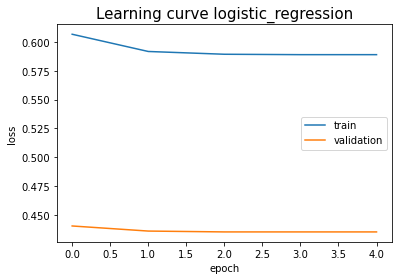

CPU times: user 1min 25s, sys: 872 ms, total: 1min 26s
Wall time: 1min 26s


In [16]:
%%time

'''Step 1: set-up'''

# This is a pathetic way to retrieve the dimensionality of input vector
input_size = next(iter(train_data_loader))['input_size'][0].item()

model = LogisticRegressionClassifier(input_size = input_size).to(device)

model_name = 'logistic_regression'

optimizer = optim.Adam(model.parameters(), lr = 2e-4)

loss_fn = nn.CrossEntropyLoss().to(device)

num_epoch = 5

best_acc = 0
best_f1_pos = 0
best_f1_neg = 0

'''Step 2: training loop '''

train_losses = []
val_losses = []

for epoch in range(num_epoch): 
    print(f'Start epoch {epoch + 1} out of {num_epoch}')
    print('-' * 10)
    
    # Train
    train_loss, train_confusion, train_acc, train_f1_pos, train_f1_neg = train_epoch_binary(
        model, train_data_loader, 
        loss_fn, optimizer, 
        device, 
        clip_grad = False  
    )
    
    # Record loss to plot learning curve 
    train_losses.append(train_loss)
    
    print(f'Train loss = {np.mean(train_loss)}', end = ', ')
    print(f'Train accuracy = {train_acc}', end = ', ')
    print(f'Train f1_pos = {train_f1_pos}', end = ', ')
    print(f'Train f1_neg = {train_f1_neg}')
    
    # Cross-validation
    val_loss, val_confusion, val_acc, val_f1_pos, val_f1_neg = eval_epoch_binary(
        model, val_data_loader, 
        loss_fn, optimizer, 
        device, 
        test_mode = False
    )
    
    # Record losses to plot learning curve 
    val_losses.append(val_loss)
    
    print(f'Validation loss = {np.mean(val_loss)}', end = ', ')
    print(f'Validation accuracy = {val_acc}', end = ', ')
    print(f'Validation f1_pos = {val_f1_pos}', end = ', ')
    print(f'Validation f1_neg = {val_f1_neg}')

    print('-' * 10)
    print(f'End epoch {epoch + 1} out of {num_epoch}', end = '\n\n')
    
    # Use accuracy as the metric to select best model 
    # Store the model with highest validation accuracy 
    if val_acc > best_acc: 
        torch.save(model.state_dict(), SESS_PWD + 'best_' + model_name + '.bin')
        best_acc = val_acc
        
        
'''Step 3: test the model'''

test_loss, test_confusion, test_acc, test_f1_pos, test_f1_neg = eval_epoch_binary(
    model, test_data_loader,  
    loss_fn, optimizer, 
    device, 
    test_mode = True
)

print(f'Test loss = {np.mean(test_loss)}', end = ', ')
print(f'Test accuracy = {test_acc}', end = ', ')
print(f'Test f1_pos = {test_f1_pos}', end = ', ')
print(f'Test f1_neg = {test_f1_neg}')

# Append information in the metric table 
metric_table.append([model_name, test_confusion, test_acc, test_f1_pos, test_f1_neg])

# Plot learning curve 
fig, ax = plt.subplots(1, 1)
ax.set_title('Learning curve ' + model_name, fontsize = 15)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.plot(train_losses, label = 'train')
ax.plot(val_losses, label = 'validation')
ax.legend()
plt.show()

        
    

### MLP classifier

Start epoch 1 out of 5
----------
Training batch #928 out of 929
Train loss = 0.586885330174018, Train accuracy = 0.7272727272727273, Train f1_pos = 0.8421052631578947, Train f1_neg = 0.0
Cross-validating batch #84 out of 85
Validation loss = 0.43092338302556205, Validation accuracy = 0.8888888888888888, Validation f1_pos = 0.9411764705882353, Validation f1_neg = 0.0
----------
End epoch 1 out of 5

Start epoch 2 out of 5
----------
Training batch #928 out of 929
Train loss = 0.5866772040035034, Train accuracy = 0.7272727272727273, Train f1_pos = 0.8421052631578947, Train f1_neg = 0.0
Cross-validating batch #84 out of 85
Validation loss = 0.43090977703823763, Validation accuracy = 0.8888888888888888, Validation f1_pos = 0.9411764705882353, Validation f1_neg = 0.0
----------
End epoch 2 out of 5

Start epoch 3 out of 5
----------
Training batch #928 out of 929
Train loss = 0.5866743089436715, Train accuracy = 0.7272727272727273, Train f1_pos = 0.8421052631578947, Train f1_neg = 0.0
Cros

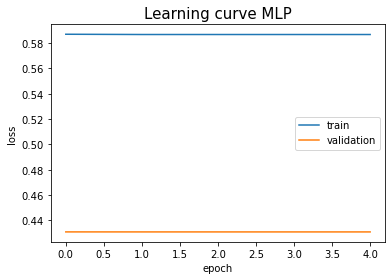

CPU times: user 1min 31s, sys: 172 ms, total: 1min 31s
Wall time: 1min 31s


In [17]:
%%time

'''Step 1: set-up'''

# This is a pathetic way to retrieve the dimensionality of input vector
input_size = next(iter(train_data_loader))['input_size'][0].item()
num_labels = 2
hidden_layers_dim = [100, 50, 70, 20, 5]

model = MLPClassifier(input_size, num_labels, hidden_layers_dim, drop_out = 0.2).to(device)

model_name = 'MLP'

optimizer = optim.Adam(model.parameters(), lr = 2e-4)

loss_fn = nn.CrossEntropyLoss().to(device)

num_epoch = 5

best_acc = 0
best_f1_pos = 0
best_f1_neg = 0

'''Step 2: training loop '''

train_losses = []
val_losses = []

for epoch in range(num_epoch): 
    print(f'Start epoch {epoch + 1} out of {num_epoch}')
    print('-' * 10)
    
    # Train
    train_loss, train_confusion, train_acc, train_f1_pos, train_f1_neg = train_epoch_binary(
        model, train_data_loader, 
        loss_fn, optimizer, 
        device, 
        clip_grad = True
    )
    
    # Record loss to plot learning curve 
    train_losses.append(train_loss)
    
    print(f'Train loss = {np.mean(train_loss)}', end = ', ')
    print(f'Train accuracy = {train_acc}', end = ', ')
    print(f'Train f1_pos = {train_f1_pos}', end = ', ')
    print(f'Train f1_neg = {train_f1_neg}')
    
    # Cross-validation
    val_loss, val_confusion, val_acc, val_f1_pos, val_f1_neg = eval_epoch_binary(
        model, val_data_loader, 
        loss_fn, optimizer, 
        device, 
        test_mode = False
    )
    
    # Record losses to plot learning curve 
    val_losses.append(val_loss)
    
    print(f'Validation loss = {np.mean(val_loss)}', end = ', ')
    print(f'Validation accuracy = {val_acc}', end = ', ')
    print(f'Validation f1_pos = {val_f1_pos}', end = ', ')
    print(f'Validation f1_neg = {val_f1_neg}')

    print('-' * 10)
    print(f'End epoch {epoch + 1} out of {num_epoch}', end = '\n\n')
    
    # Use accuracy as the metric to select best model 
    # Store the model with highest validation accuracy 
    if val_acc > best_acc: 
        torch.save(model.state_dict(), SESS_PWD + 'best_' + model_name + '.bin')
        best_acc = val_acc
        
        
'''Step 3: test the model'''

test_loss, test_confusion, test_acc, test_f1_pos, test_f1_neg = eval_epoch_binary(
    model, test_data_loader, 
    loss_fn, optimizer, 
    device, 
    test_mode = True
)

print(f'Test loss = {np.mean(test_loss)}', end = ', ')
print(f'Test accuracy = {test_acc}', end = ', ')
print(f'Test f1_pos = {test_f1_pos}', end = ', ')
print(f'Test f1_neg = {test_f1_neg}')

# Append information in the metric table 
metric_table.append([model_name, test_confusion, test_acc, test_f1_pos, test_f1_neg])

# Plot learning curve 
fig, ax = plt.subplots(1, 1)
ax.set_title('Learning curve ' + model_name, fontsize = 15)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.plot(train_losses, label = 'train')
ax.plot(val_losses, label = 'validation')
ax.legend()
plt.show()

        
    

Start epoch 1 out of 5
----------
Training batch #928 out of 929
Train loss = 0.04748497720570098, Train accuracy = 0.9948148148148148, Train f1_pos = 0.9964435822825736, Train f1_neg = 0.9904335942353087
Cross-validating batch #84 out of 85
Validation loss = 9.41896083115158, Validation accuracy = 0.1111111111111111, Validation f1_pos = 0.0, Validation f1_neg = 0.2
----------
End epoch 1 out of 5

Start epoch 2 out of 5
----------
Training batch #928 out of 929
Train loss = 7.442119991900385, Train accuracy = 0.2727272727272727, Train f1_pos = 0.0, Train f1_neg = 0.42857142857142855
Cross-validating batch #84 out of 85
Validation loss = 9.41896083115158, Validation accuracy = 0.1111111111111111, Validation f1_pos = 0.0, Validation f1_neg = 0.2
----------
End epoch 2 out of 5

Start epoch 3 out of 5
----------
Training batch #928 out of 929
Train loss = 7.44053776893307, Train accuracy = 0.2727272727272727, Train f1_pos = 0.0, Train f1_neg = 0.42857142857142855
Cross-validating batch #

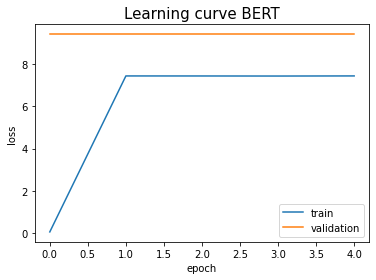

CPU times: user 36min, sys: 12min 42s, total: 48min 43s
Wall time: 48min 51s


In [18]:
%%time

'''Step 1: set-up'''

# This is a pathetic way to retrieve the dimensionality of input vector
input_size = next(iter(train_data_loader))['input_size'][0].item()
num_labels = 2
hidden_layers_dim = [100, 50, 70, 20, 5]

model = BertClassifier(num_labels = 2, drop_out = 0.2).to(device)

model_name = 'BERT'

optimizer = optim.Adam(model.parameters(), lr = 2e-4)

scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 0, 
    num_training_steps = len(train_data_loader)
)

loss_fn = nn.CrossEntropyLoss().to(device)

num_epoch = 5

best_acc = 0
best_f1_pos = 0
best_f1_neg = 0

'''Step 2: training loop '''

train_losses = []
val_losses = []

for epoch in range(num_epoch): 
    print(f'Start epoch {epoch + 1} out of {num_epoch}')
    print('-' * 10)
    
    # Train
    train_loss, train_confusion, train_acc, train_f1_pos, train_f1_neg = train_epoch_binary(
        model, train_data_loader, 
        loss_fn, optimizer, 
        device, 
        clip_grad = True, 
        scheduler = scheduler
    )
    
    # Record loss to plot learning curve 
    train_losses.append(train_loss)
    
    print(f'Train loss = {np.mean(train_loss)}', end = ', ')
    print(f'Train accuracy = {train_acc}', end = ', ')
    print(f'Train f1_pos = {train_f1_pos}', end = ', ')
    print(f'Train f1_neg = {train_f1_neg}')
    
    # Cross-validation
    val_loss, val_confusion, val_acc, val_f1_pos, val_f1_neg = eval_epoch_binary(
        model, val_data_loader, 
        loss_fn, optimizer, 
        device, 
        test_mode = False
    )
    
    # Record losses to plot learning curve 
    val_losses.append(val_loss)
    
    print(f'Validation loss = {np.mean(val_loss)}', end = ', ')
    print(f'Validation accuracy = {val_acc}', end = ', ')
    print(f'Validation f1_pos = {val_f1_pos}', end = ', ')
    print(f'Validation f1_neg = {val_f1_neg}')

    print('-' * 10)
    print(f'End epoch {epoch + 1} out of {num_epoch}', end = '\n\n')
    
    # Use accuracy as the metric to select best model 
    # Store the model with highest validation accuracy 
    if val_acc > best_acc: 
        torch.save(model.state_dict(), SESS_PWD + 'best_' + model_name + '.bin')
        best_acc = val_acc
        
        
'''Step 3: test the model'''

test_loss, test_confusion, test_acc, test_f1_pos, test_f1_neg = eval_epoch_binary(
    model, test_data_loader, 
    loss_fn, optimizer, 
    device, 
    test_mode = True
)

print(f'Test loss = {np.mean(test_loss)}', end = ', ')
print(f'Test accuracy = {test_acc}', end = ', ')
print(f'Test f1_pos = {test_f1_pos}', end = ', ')
print(f'Test f1_neg = {test_f1_neg}')

# Append information in the metric table 
metric_table.append([model_name, test_confusion, test_acc, test_f1_pos, test_f1_neg])

# Plot learning curve 
fig, ax = plt.subplots(1, 1)
ax.set_title('Learning curve ' + model_name, fontsize = 15)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.plot(train_losses, label = 'train')
ax.plot(val_losses, label = 'validation')
ax.legend()
plt.show()

    
    

### Show final result for comparison 

In [19]:
pd.DataFrame(metric_table, columns = colNames)

,model_name,test_confusion_matrix,test_accuracy,test_f1_pos,test_f1_neg
0,logistic_regression,"[[2, 399], [37, 9563]]",0.956404,0.977712,0.009091
1,MLP,"[[0, 401], [0, 9600]]",0.959904,0.979542,0.000000
2,BERT,"[[401, 0], [9600, 0]]",0.040096,0.000000,0.077101


Takeout messages: 
    
1. Giant deep learning model (like BERT) may not work on small dataset; 

1. Need to explore better upsampling techniques